Reading data from 30mm10hz1A.csv...
[0.000e+00 1.000e-03 2.000e-03 ... 5.373e+00 5.374e+00 5.375e+00]
[27.184229 27.184229 27.184229 ... 29.013225 29.282195 29.282195]
Loaded 5376 data points
Calculating acceleration using 5-point differentiation...
0.001
[-179.31333333   67.2425      -89.65666667 ...  313.79833333  179.31333333
 -224.14166667]
[ 920848.68055555 -149427.77777777  -54167.56944444 ...   47630.10416667
 -309128.71527778 -424935.2430556 ]
[ 920848.68055555 -149427.77777777  -54167.56944444 ...   47630.10416667
 -309128.71527778 -424935.2430556 ]
Smoothing displacement data...
Analyzing frequency and amplitude...
5.375
5686.722876651821
59
11.033652323219217
Dominant frequency: 11.034 Hz
Amplitude: 183.578
Creating plots...

=== Analysis Summary ===
Time range: 0.000 to 5.375 seconds
Sampling rate: 1000.00 Hz
Oscillation frequency: 11.034 Hz
Period: 0.091 seconds
Acceleration amplitude: 183.578
Fitted sine parameters:
  - Amplitude: 0.019g
  - Phase: -0.258 radians
  - Offs

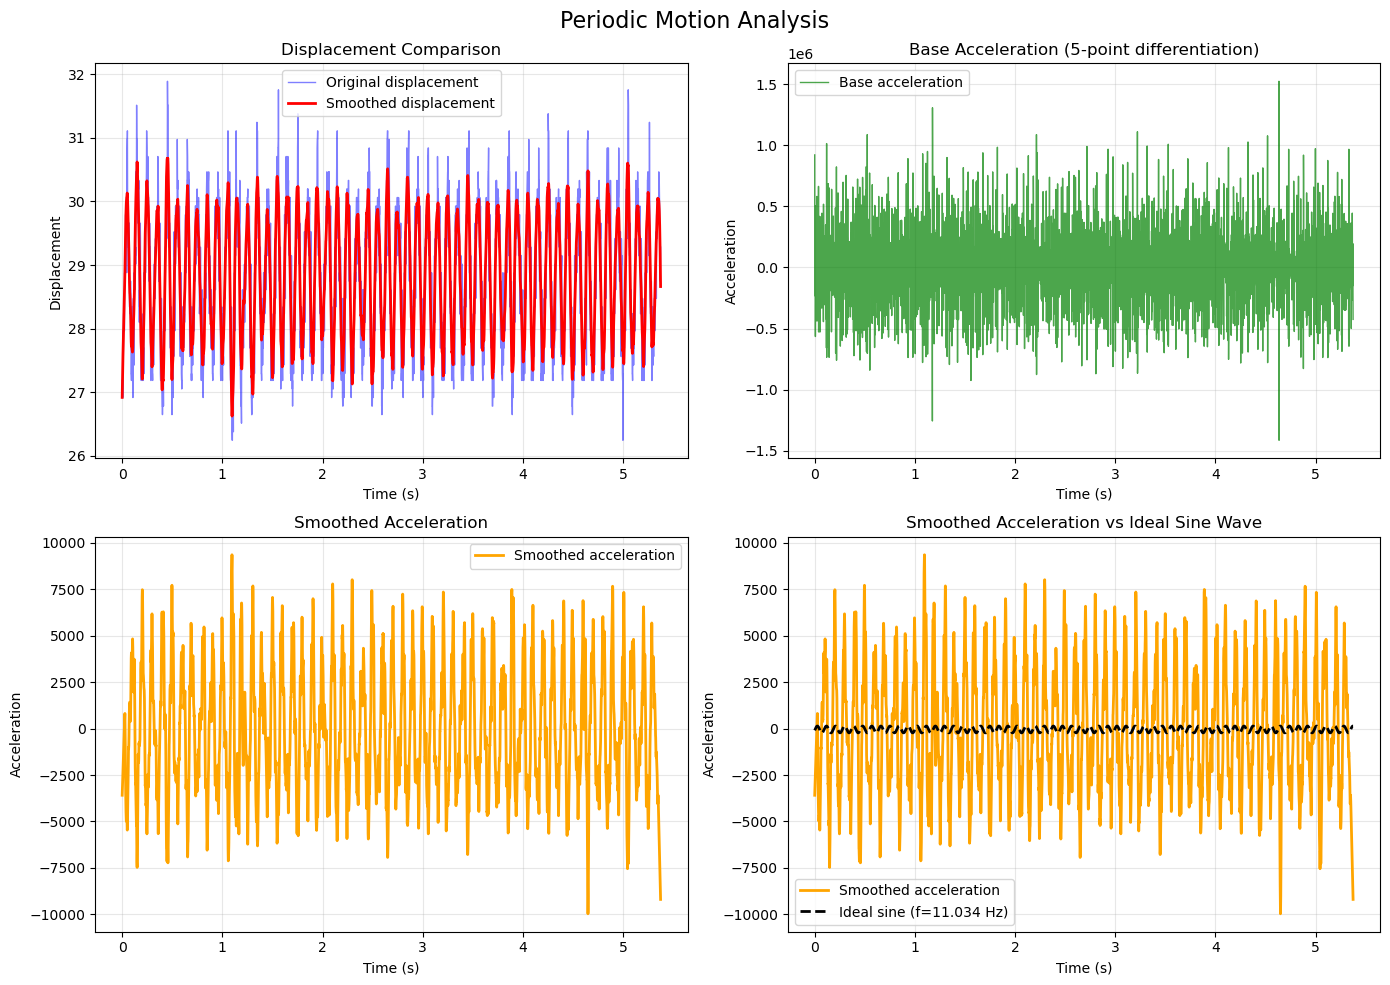


Analysis complete! Plots should be displayed.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import curve_fit


def five_point_differentiation(y, h):
    """
    Calculate derivative using 5-point midpoint differentiation scheme.
    Uses central differences for interior points and forward/backward for endpoints.
    """
    n = len(y)
    dy = np.zeros(n)
    
    # Forward difference for first two points
    dy[0] = (-25*y[0] + 48*y[1] - 36*y[2] + 16*y[3] - 3*y[4]) / (12*h)
    dy[1] = (-3*y[0] - 10*y[1] + 18*y[2] - 6*y[3] + y[4]) / (12*h)
    
    # 5-point central difference for interior points
    for i in range(2, n-2):
        dy[i] = (y[i-2] - 8*y[i-1] + 8*y[i+1] - y[i+2]) / (12*h)
    
    # Backward difference for last two points
    dy[n-2] = (-y[n-5] + 6*y[n-4] - 18*y[n-3] + 10*y[n-2] + 3*y[n-1]) / (12*h)
    dy[n-1] = (3*y[n-5] - 16*y[n-4] + 36*y[n-3] - 48*y[n-2] + 25*y[n-1]) / (12*h)
    
    return dy

def calculate_acceleration(time, displacement):
    """Calculate acceleration from displacement using double differentiation."""
    dt = time[1]-time[0]
    print(dt)
    # First derivative (velocity)
    velocity = five_point_differentiation(displacement, dt)
    print(velocity)
    # Second derivative (acceleration)
    acceleration = five_point_differentiation(velocity, dt)
    print(acceleration)
    return acceleration

def find_frequency_amplitude(time, signal):
    """
    Find dominant frequency and amplitude using FFT.
    """
    # Remove DC component
    def sine_function(x, A, B, C):
        return A * np.sin(2 * np.pi*B * x + C)
    # Initial guesses for parameters (A, B, C, D)
    time=time[~np.isnan(signal)]
    signal= signal[~np.isnan(signal)]
    initial_A=np.percentile(signal, 95)
    from scipy.signal import find_peaks
    intervals_time=np.diff(time)
    filtered_intervals=intervals_time[intervals_time<=np.percentile(intervals_time, 99.5)]
    total_time=np.sum(filtered_intervals)
    print(total_time)

    # Find the peaks in the signal
    # The find_peaks function returns the indices of the peaks
    peaks_indices, _ = find_peaks(signal,prominence=(initial_A/2))

    # The number of peaks is simply the length of the peaks_indices array
    num_peaks = len(peaks_indices)
    initial_guesses = [initial_A, num_peaks/total_time, 0] 
    print(initial_A)
    print(num_peaks)
    # Perform the fit
    params, covariance = curve_fit(sine_function, time, signal, p0=initial_guesses,method = 'lm')
    
    # Extract fitted parameters
    A_fit, B_fit, C_fit = params
    print(B_fit)
    return(B_fit,A_fit)

def fit_sine_wave(time, signal, frequency):
    """
    Fit a sine wave with known frequency to find amplitude and phase.
    """
    time=time[~np.isnan(signal)]
    signal= signal[~np.isnan(signal)]
    def sine_func(t, A, phi, C):
        return A * np.sin(2 * np.pi * frequency * t + phi) + C
    
    # Initial guess
    A_guess = (np.max(signal) - np.min(signal)) / 2
    C_guess = np.mean(signal)
    
    try:
        popt, _ = curve_fit(sine_func, time, signal, 
                           p0=[A_guess, 0, C_guess],
                           bounds=([-np.inf, -np.pi, -np.inf], 
                                 [np.inf, np.pi, np.inf]))
        return popt  # Returns [amplitude, phase, offset]
    except:
        return [A_guess, 0, C_guess]

def main(csv_filename):
    """
    Main analysis function.
    
    Parameters:
    -----------
    csv_filename : str
        Path to CSV file with time and displacement columns
    """
    
    # Read CSV data
    print(f"Reading data from {csv_filename}...")
    df = pd.read_csv(csv_filename, header=None)
    
    # Extract time and displacement (first two columns)
    time = df.iloc[:, 0].values
    displacement = df.iloc[:, 1].values
    print(time)
    print(displacement)
    print(f"Loaded {len(time)} data points")
    
    # Calculate base acceleration
    print("Calculating acceleration using 5-point differentiation...")
    base_acceleration = calculate_acceleration(time, displacement)
    print(base_acceleration)
    # Smooth displacement using Savitzky-Golay filter
    print("Smoothing displacement data...")
    # Window length should be odd and less than data length
    window_length = 50
    polyorder = 3
    deltaT=time[1]-time[0]
    smoothed_displacement = savgol_filter(displacement, window_length, polyorder)
    window_length = 50
    polyorder = 3
    deltaT=time[1]-time[0]
    smoothed_acceleration = savgol_filter(displacement, window_length, polyorder, deriv=2,delta=deltaT)
    
    
    # Determine frequency and amplitude of smoothed acceleration
    print("Analyzing frequency and amplitude...")
    frequency, amplitude = find_frequency_amplitude(time, smoothed_acceleration)
    print(f"Dominant frequency: {frequency:.3f} Hz")
    print(f"Amplitude: {amplitude:.3f}")
    
    # Fit sine wave to smoothed acceleration
    fitted_params = fit_sine_wave(time, smoothed_acceleration, frequency)
    ideal_sine = fitted_params[0] * np.sin(2 * np.pi * frequency * time + fitted_params[1]) + fitted_params[2]
    
    # Create plots
    print("Creating plots...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Periodic Motion Analysis', fontsize=16)
    
    # Plot 1: Base and smoothed displacement
    ax1 = axes[0, 0]
    ax1.plot(time, displacement, 'b-', alpha=0.5, label='Original displacement', linewidth=1)
    ax1.plot(time, smoothed_displacement, 'r-', label='Smoothed displacement', linewidth=2)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Displacement')
    ax1.set_title('Displacement Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Base acceleration
    ax2 = axes[0, 1]
    ax2.plot(time, base_acceleration, 'g-', alpha=0.7, label='Base acceleration', linewidth=1)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Acceleration')
    ax2.set_title('Base Acceleration (5-point differentiation)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Smoothed acceleration
    ax3 = axes[1, 0]
    ax3.plot(time, smoothed_acceleration, 'orange', label='Smoothed acceleration', linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Acceleration')
    ax3.set_title('Smoothed Acceleration')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Smoothed acceleration vs ideal sine wave
    ax4 = axes[1, 1]
    ax4.plot(time, smoothed_acceleration, 'orange', label='Smoothed acceleration', linewidth=2)
    ax4.plot(time, ideal_sine, 'k--', label=f'Ideal sine (f={frequency:.3f} Hz)', linewidth=2)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Acceleration')
    ax4.set_title('Smoothed Acceleration vs Ideal Sine Wave')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Print analysis summary
    print("\n=== Analysis Summary ===")
    print(f"Time range: {time[0]:.3f} to {time[-1]:.3f} seconds")
    print(f"Sampling rate: {1/np.mean(np.diff(time)):.2f} Hz")
    print(f"Oscillation frequency: {frequency:.3f} Hz")
    print(f"Period: {1/frequency:.3f} seconds")
    print(f"Acceleration amplitude: {amplitude:.3f}")
    print(f"Fitted sine parameters:")
    print(f"  - Amplitude: {fitted_params[0]/9800:.3f}g")
    print(f"  - Phase: {fitted_params[1]:.3f} radians")
    print(f"  - Offset: {fitted_params[2]:.3f}")
    
    # Calculate RMS error between smoothed acceleration and ideal sine
    rms_error = np.sqrt(np.mean((smoothed_acceleration - ideal_sine)**2))
    print(f"RMS error (smoothed vs ideal): {rms_error:.4f}")
    
    plt.show()
    
    return {
        'time': time,
        'displacement': displacement,
        'smoothed_displacement': smoothed_displacement,
        'base_acceleration': base_acceleration,
        'smoothed_acceleration': smoothed_acceleration,
        'frequency': frequency,
        'amplitude': amplitude,
        'ideal_sine': ideal_sine
    }

if __name__ == "__main__":
    # Specify your CSV filename here
    csv_filename = "30mm10hz1A.csv"  # Change this to your actual file name
    
    try:
        results = main(csv_filename)
        print("\nAnalysis complete! Plots should be displayed.")
    except FileNotFoundError:
        print(f"Error: Could not find file '{csv_filename}'")
        print("Please make sure the CSV file exists in the same directory as this script.")
    except Exception as e:
        print(f"An error occurred: {e}")
        print("Please check that your CSV file has the correct format (time in first column, displacement in second)")
